In [1]:
import sys; sys.path.insert(0, "../")

import warnings
warnings.simplefilter("ignore", UserWarning)
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as dists
import numpy as np
import helper.wideresnet as wrn
import helper.dataloaders as dl
from helper import util
from helper.calibration_gp_utils import predict, gp_calibration_eval
from netcal.metrics import ECE

from laplace import Laplace

from helper.datasets import get_dataset
from helper.models import get_model
from torch.utils.data import DataLoader

/home/metod/miniconda3/envs/laplace/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(7777)
torch.manual_seed(7777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
print(torch.has_mps)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

False
True
1
0
NVIDIA GeForce GTX 1080 Ti


In [17]:
REPO = "BNN-preds"
# REPO = "Laplace"

DATASET = "FMNIST"
# DATASET = "CIFAR10"

SUBSET_OF_WEIGHTS = "last_layer"
# SUBSET_OF_WEIGHTS = "all"

# option REPO="Laplace" & DATASET="CIFAR10" & SUBSET_OF_WEIGHTS = "last_layer" can not be evaluated since the model AllCNN does not have linear last layer 

In [18]:
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
EXPERIMENT_NAME = f"{DATASET}_{SUBSET_OF_WEIGHTS}_{dt_string}_{REPO}"

## 1) init

### data

In [6]:
if REPO == "BNN-preds":
    ds_train, ds_test = get_dataset(DATASET, False, 'cuda')
    train_loader = DataLoader(ds_train, batch_size=128, shuffle=True)
    test_loader = DataLoader(ds_test, batch_size=100, shuffle=False)
    targets = torch.cat([y for x, y in test_loader], dim=0).cpu()
elif REPO == "Laplace":
    assert DATASET == "CIFAR10"
    train_loader = dl.CIFAR10(train=True)
    test_loader = dl.CIFAR10(train=False)
    targets = torch.cat([y for x, y in test_loader], dim=0).cpu()

### model

In [7]:
if REPO == "BNN-preds":
    if DATASET == "FMNIST":
        model = get_model('CNN', ds_train).to('cuda')
        # state = torch.load("helper/models/FMNIST_CNN_117_4.6e-01.pt")
        state = torch.load("helper/models/FMNIST_CNN_117_1.0e+01.pt")
        
    elif DATASET == "CIFAR10":
        model = get_model('AllCNN', ds_train).to('cuda')
        state = torch.load("helper/models/CIFAR10_AllCNN_117_1.0e+01.pt")
    model.load_state_dict(state['model'])
    model = model.cuda()
else:
    assert DATASET == "CIFAR10"
    # The model is a standard WideResNet 16-4
    # Taken as is from https://github.com/hendrycks/outlier-exposure
    model = wrn.WideResNet(16, 4, num_classes=10).cuda().eval()
    # print( sum(p.numel() for p in model.parameters()))

    util.download_pretrained_model()
    model.load_state_dict(torch.load('./temp/CIFAR10_plain.pt'))

## 2) baselines

### MAP

In [8]:
probs_map = predict(test_loader, model, laplace=False)
acc_map = (probs_map.argmax(-1) == targets).float().mean()
ece_map = ECE(bins=15).measure(probs_map.numpy(), targets.numpy())
nll_map = -dists.Categorical(probs_map).log_prob(targets).mean()

print(f'[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}')
MAP_METRICS = {"acc": acc_map, "ece": ece_map, "nll": nll_map}

[MAP] Acc.: 92.2%; ECE: 5.4%; NLL: 0.392


### Parametric Laplace

In [9]:
la = Laplace(model, 'classification',
             subset_of_weights=SUBSET_OF_WEIGHTS,
             hessian_structure='kron')
la.fit(train_loader)
la.optimize_prior_precision(method='marglik')

probs_laplace = predict(test_loader, la, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).float().mean()
ece_laplace = ECE(bins=15).measure(probs_laplace.numpy(), targets.numpy())
nll_laplace = -dists.Categorical(probs_laplace).log_prob(targets).mean()

print(f'[Laplace] Acc.: {acc_laplace:.1%}; ECE: {ece_laplace:.1%}; NLL: {nll_laplace:.3}')
PARAM_LAPLACE_METRICS = {"acc": acc_laplace, "ece": ece_laplace, "nll": nll_laplace}

[Laplace] Acc.: 92.2%; ECE: 4.1%; NLL: 0.311


## 3) Functional Laplace (GP)

In [10]:
metrics_gp = gp_calibration_eval(model=model, train_loader=train_loader, 
                                 subset_of_weights=SUBSET_OF_WEIGHTS, test_loader=test_loader,
                                 M_arr=[50, 100, 200, 400, 800, 1600]) 
                                 # M_arr=[50, 100, 200, 400, 800, 1600, 3200])

50 0
[Laplace] Acc.: 92.3%; ECE: 4.8%; NLL: 0.339


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 1
[Laplace] Acc.: 92.2%; ECE: 4.8%; NLL: 0.337


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 2
[Laplace] Acc.: 92.2%; ECE: 4.8%; NLL: 0.337


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 3
[Laplace] Acc.: 92.2%; ECE: 4.7%; NLL: 0.337


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 4
[Laplace] Acc.: 92.2%; ECE: 4.8%; NLL: 0.337


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 0
[Laplace] Acc.: 92.2%; ECE: 4.2%; NLL: 0.316


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 1
[Laplace] Acc.: 92.1%; ECE: 4.2%; NLL: 0.318


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 2
[Laplace] Acc.: 92.1%; ECE: 4.3%; NLL: 0.317


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 3
[Laplace] Acc.: 92.2%; ECE: 4.0%; NLL: 0.311


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 4
[Laplace] Acc.: 92.2%; ECE: 4.2%; NLL: 0.312


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


200 0
[Laplace] Acc.: 92.2%; ECE: 3.4%; NLL: 0.31


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


200 1
[Laplace] Acc.: 92.2%; ECE: 3.2%; NLL: 0.308


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


200 2
[Laplace] Acc.: 92.1%; ECE: 3.2%; NLL: 0.309


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


200 3
[Laplace] Acc.: 92.1%; ECE: 2.9%; NLL: 0.303


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


200 4
[Laplace] Acc.: 92.2%; ECE: 3.2%; NLL: 0.293


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


400 0
[Laplace] Acc.: 92.2%; ECE: 2.6%; NLL: 0.302


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


400 1
[Laplace] Acc.: 92.2%; ECE: 2.0%; NLL: 0.307


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


400 2
[Laplace] Acc.: 92.1%; ECE: 1.5%; NLL: 0.317


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


400 3
[Laplace] Acc.: 92.0%; ECE: 2.0%; NLL: 0.312


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


400 4
[Laplace] Acc.: 92.2%; ECE: 2.4%; NLL: 0.294


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


800 0
[Laplace] Acc.: 92.2%; ECE: 2.5%; NLL: 0.307


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


800 1
[Laplace] Acc.: 92.3%; ECE: 2.1%; NLL: 0.306


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


800 2
[Laplace] Acc.: 92.1%; ECE: 2.1%; NLL: 0.313


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


800 3
[Laplace] Acc.: 92.2%; ECE: 2.1%; NLL: 0.317


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


800 4
[Laplace] Acc.: 92.0%; ECE: 2.4%; NLL: 0.314


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1600 0
[Laplace] Acc.: 92.1%; ECE: 2.9%; NLL: 0.315


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1600 1
[Laplace] Acc.: 92.1%; ECE: 2.6%; NLL: 0.313


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1600 2
[Laplace] Acc.: 92.2%; ECE: 3.2%; NLL: 0.323


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1600 3
[Laplace] Acc.: 92.2%; ECE: 3.5%; NLL: 0.322


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1600 4
[Laplace] Acc.: 92.1%; ECE: 3.5%; NLL: 0.317


/home/metod/Desktop/PhD/year1/Laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


In [11]:
metrics_gp["acc_laplace"] = metrics_gp["acc_laplace"].apply(lambda x: x.cpu().item())
metrics_gp["nll_laplace"] = metrics_gp["nll_laplace"].apply(lambda x: x.cpu().item())

In [12]:
metrics_gp

,M,seed,acc_laplace,ece_laplace,nll_laplace
0,50,0,0.9225,0.047661,0.339286
1,50,1,0.9220,0.047663,0.337458
2,50,2,0.9221,0.047514,0.337451
3,50,3,0.9221,0.047469,0.337264
4,50,4,0.9222,0.047505,0.337386
5,100,0,0.9222,0.042424,0.316404
6,100,1,0.9213,0.042350,0.318159
7,100,2,0.9209,0.042553,0.317037
8,100,3,0.9221,0.040251,0.311399
9,100,4,0.9216,0.041654,0.311985


In [13]:
metrics_gp.to_csv(f"results/{EXPERIMENT_NAME}")

## 4) results

In [20]:
# EXPERIMENT_NAME = "FMNIST_last_layer_23_12_2022_10_57_37_BNN-preds"
EXPERIMENT_NAME = "FMNIST_last_layer_29_12_2022_12_37_13_BNN-preds"

In [21]:
metrics_gp = pd.read_csv(f"results/{EXPERIMENT_NAME}")

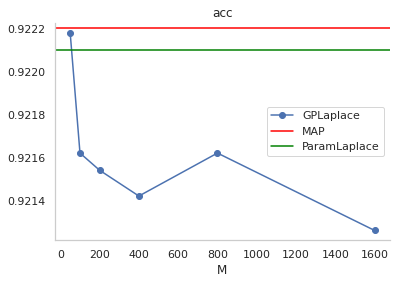

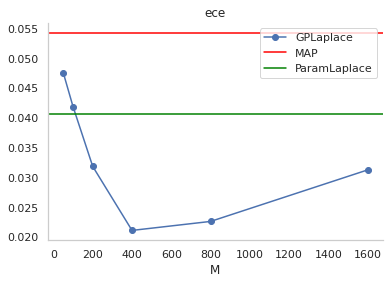

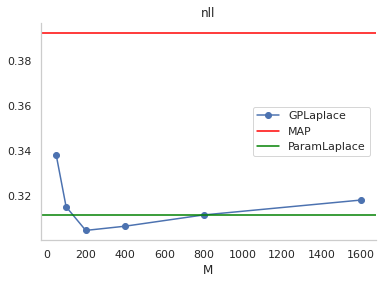

In [22]:
for metric in ["acc_laplace", "ece_laplace", "nll_laplace"]:
    metrics_gp.groupby(by="M")[[metric]].mean().rename({metric: "GPLaplace"}, axis=1).plot(style="-bo")
    plt.axhline(y=MAP_METRICS[metric[:3]], label="MAP", color="red")
    plt.axhline(y=PARAM_LAPLACE_METRICS[metric[:3]], label="ParamLaplace", color="green")
    plt.title(metric[:3])
    plt.legend()
    plt.show()